# Make Necessary Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Unpack Dataset

In [2]:
raw_data = load_breast_cancer()
features = raw_data.data
target = raw_data.target
feature_names = raw_data.feature_names
target_names = raw_data.target_names

print(raw_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

## Organize the data in a dataframe

In [3]:
df = pd.DataFrame(
    data = features,
    columns = feature_names
)
df['target'] = target

# Data Preprocessing

### Check for Null Values

In [4]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

# Exploratory Data Analysis

In [5]:
# sns.pairplot(df)

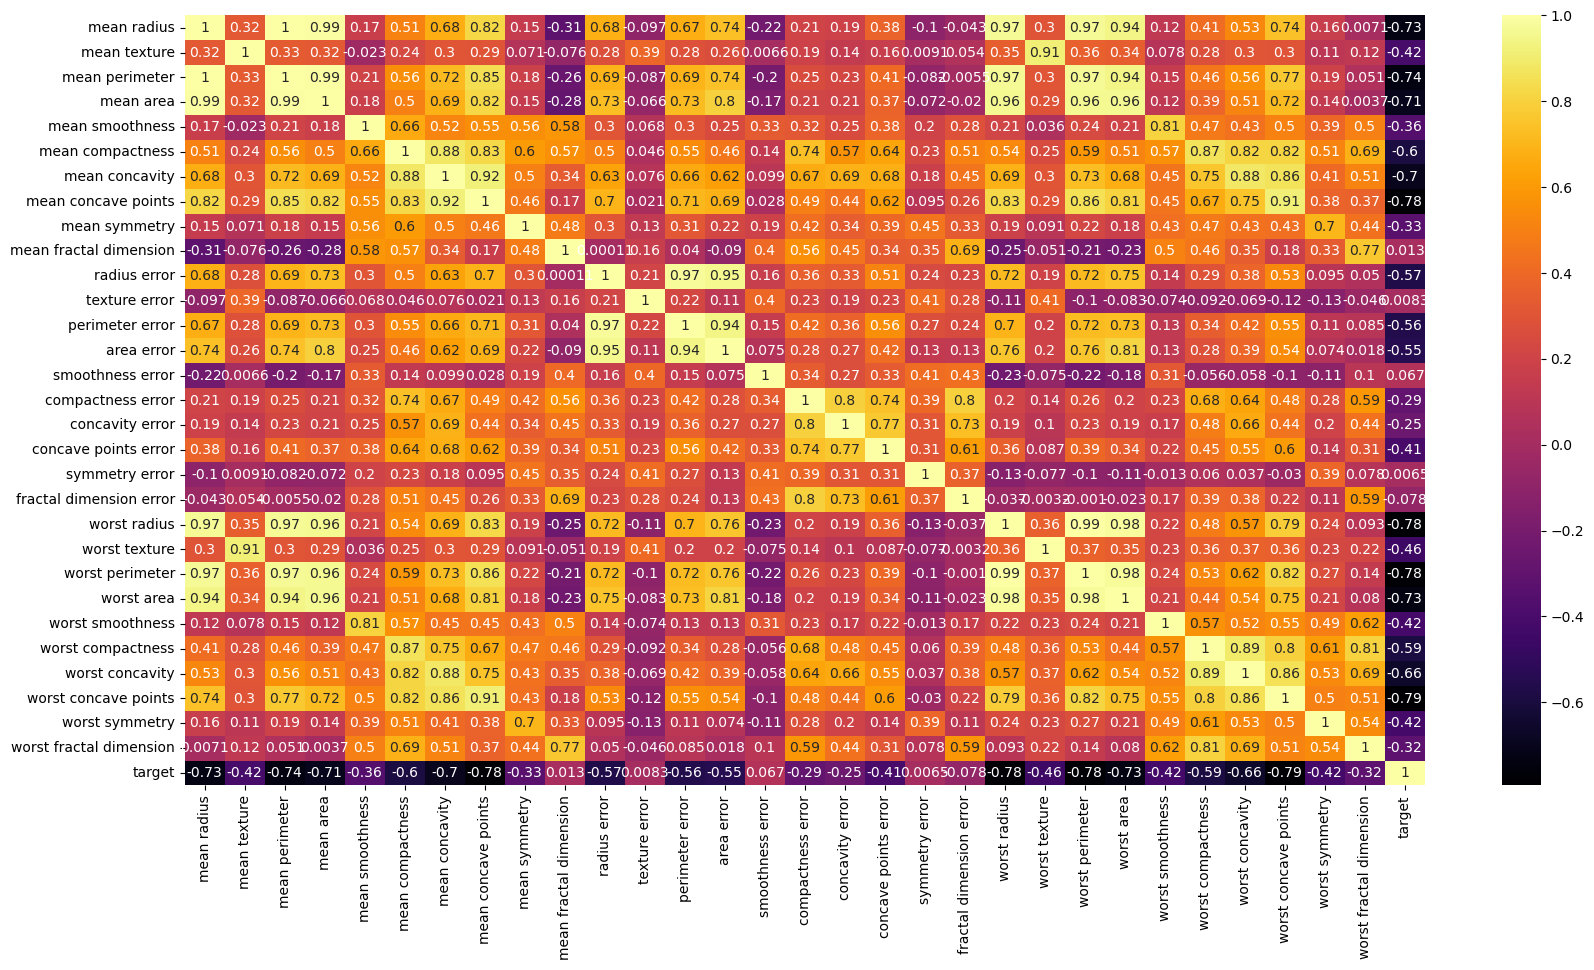

In [6]:
plt.figure(figsize=(20, 10))

sns.heatmap(
    df.corr(),
    annot=True,
    cmap='inferno'
)

plt.show()

> #### From the figure above:
>
> * The ***mean radius***, ***mean perimeter*** and ***mean area*** features are highly correlated, indicating multicollinearity.
> * The ***worst radius***, ***worst perimeter*** and ***worst area*** features are also highly correlated, indicating multicollinearity.
> * The ***radius error***, ***perimeter error*** and ***area error*** features are also highly correlated, indicating multicollinearity.

> In each case, the correlated features will be combined using Principal Component Analysis.

In [7]:
group_1 = df[['mean radius', 'mean perimeter', 'mean area']]
group_2 = df[['worst radius', 'worst perimeter', 'worst area']]
group_3 = df[['radius error', 'perimeter error', 'area error']]

def pca_transform(group):
    scaler = StandardScaler()
    group_scaled = scaler.fit_transform(group)

    pca = PCA(n_components = 1)
    group_combined = pca.fit_transform(group_scaled)
    return group_combined

df['mean_radius_perimeter_area'] = pca_transform(group_1)
df['worst_radius_perimeter_area'] = pca_transform(group_2)
df['radius_perimeter_area_error'] = pca_transform(group_3)

In [8]:
correlated_groups = group_1.columns.to_list() + group_2.columns.to_list() + group_3.columns.to_list() 
df = df.drop(correlated_groups, axis = 1)

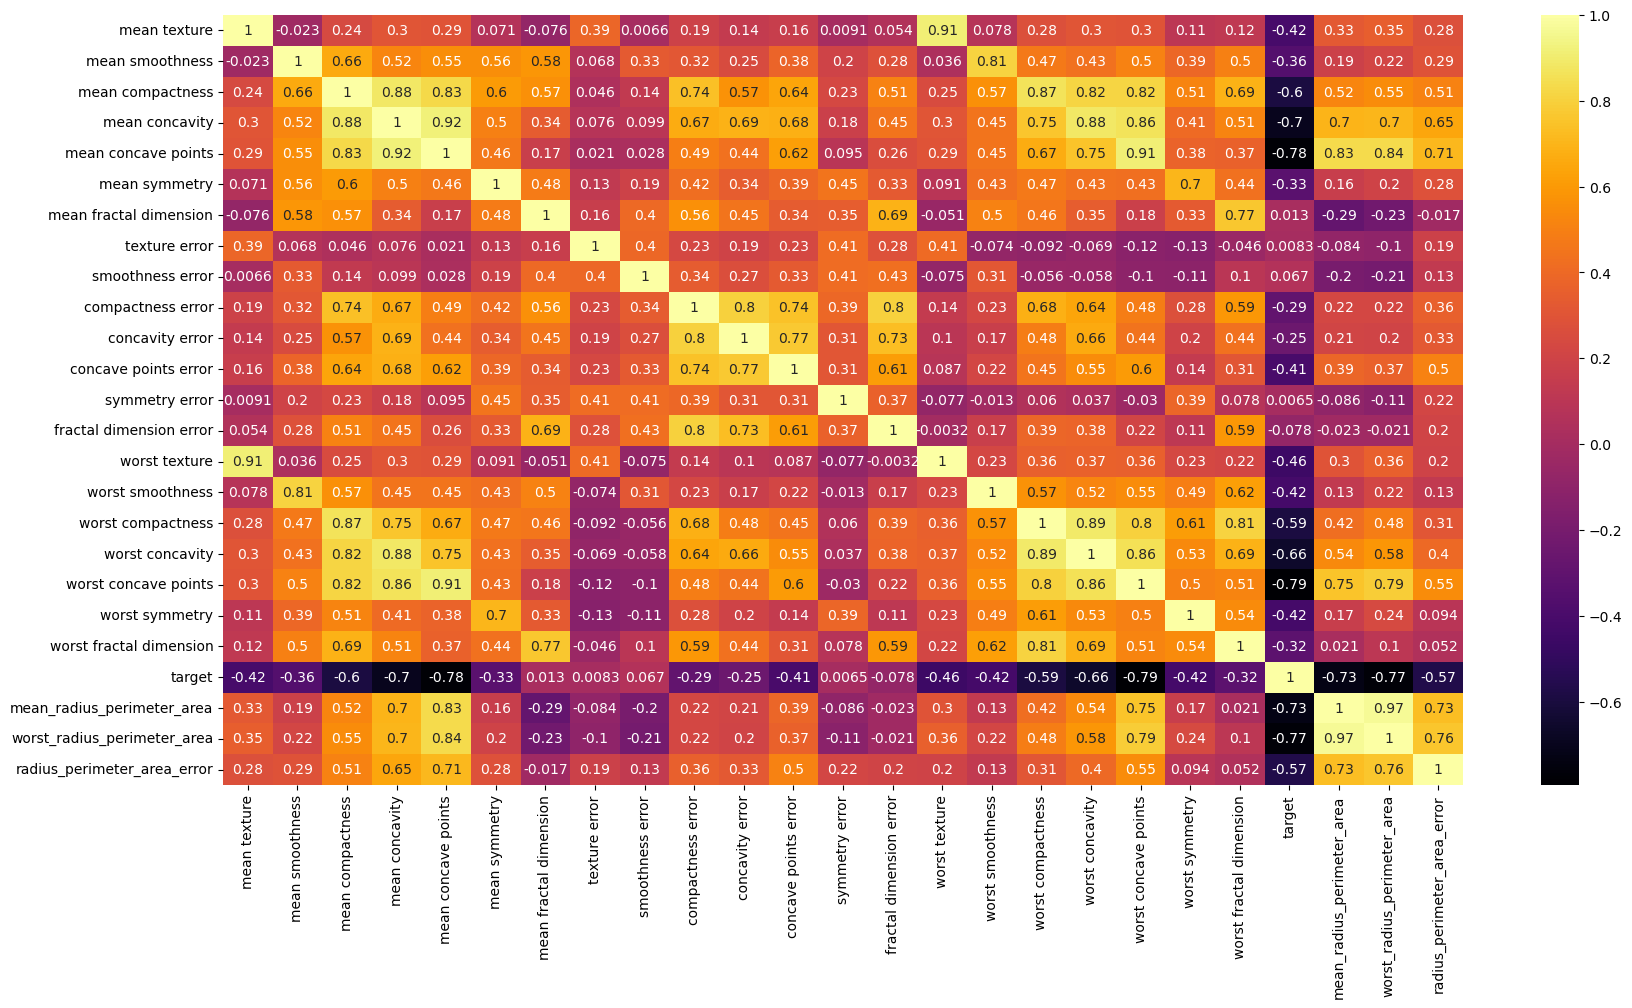

In [9]:
plt.figure(figsize=(20, 10))

sns.heatmap(
    df.corr(),
    annot=True,
    cmap='inferno'
)

plt.show()

In [10]:
df.shape
# df

(569, 25)

## Split into Training and Testing Sets

In [11]:
X = df.drop(['target'], axis = 1)
y = df['target']

# y.value_counts(normalize = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = .2,
                                                   stratify = y,
                                                   random_state = 365)

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using KNNs

## Perform Cross Validation

In [40]:
params = {
    'n_neighbors': np.arange(1, 101),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

In [41]:
cv = GridSearchCV(KNeighborsClassifier(),
                  param_grid = params,
                  scoring = 'accuracy'
                 )

cv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

## Initialize Model

In [42]:
knn = cv.best_estimator_
knn

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

## Make Predictions

In [43]:
y_test_pred = knn.predict(X_test)

## Model Evaluation

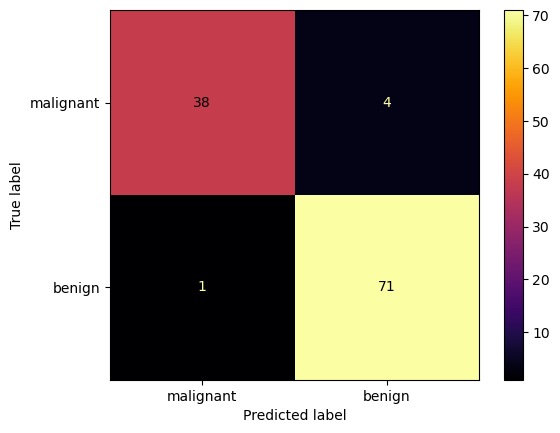

In [44]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    cmap = 'inferno',
    display_labels = target_names
)

In [45]:
print(classification_report(
    y_test,
    y_test_pred,
    target_names = target_names
))

              precision    recall  f1-score   support

   malignant       0.97      0.90      0.94        42
      benign       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [46]:
print(accuracy_score(
    y_test,
    y_test_pred
))

0.956140350877193


# Using Decision Trees

## Perform Cross Validation

In [20]:
dtc_params = {
    'ccp_alpha': [0.1, 0.01, 0.001, 0.0001]
}

In [21]:
dtc_cv = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = dtc_params,
                      scoring = 'accuracy'
                      )

dtc_cv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy')

In [22]:
dt_clf = dtc_cv.best_estimator_

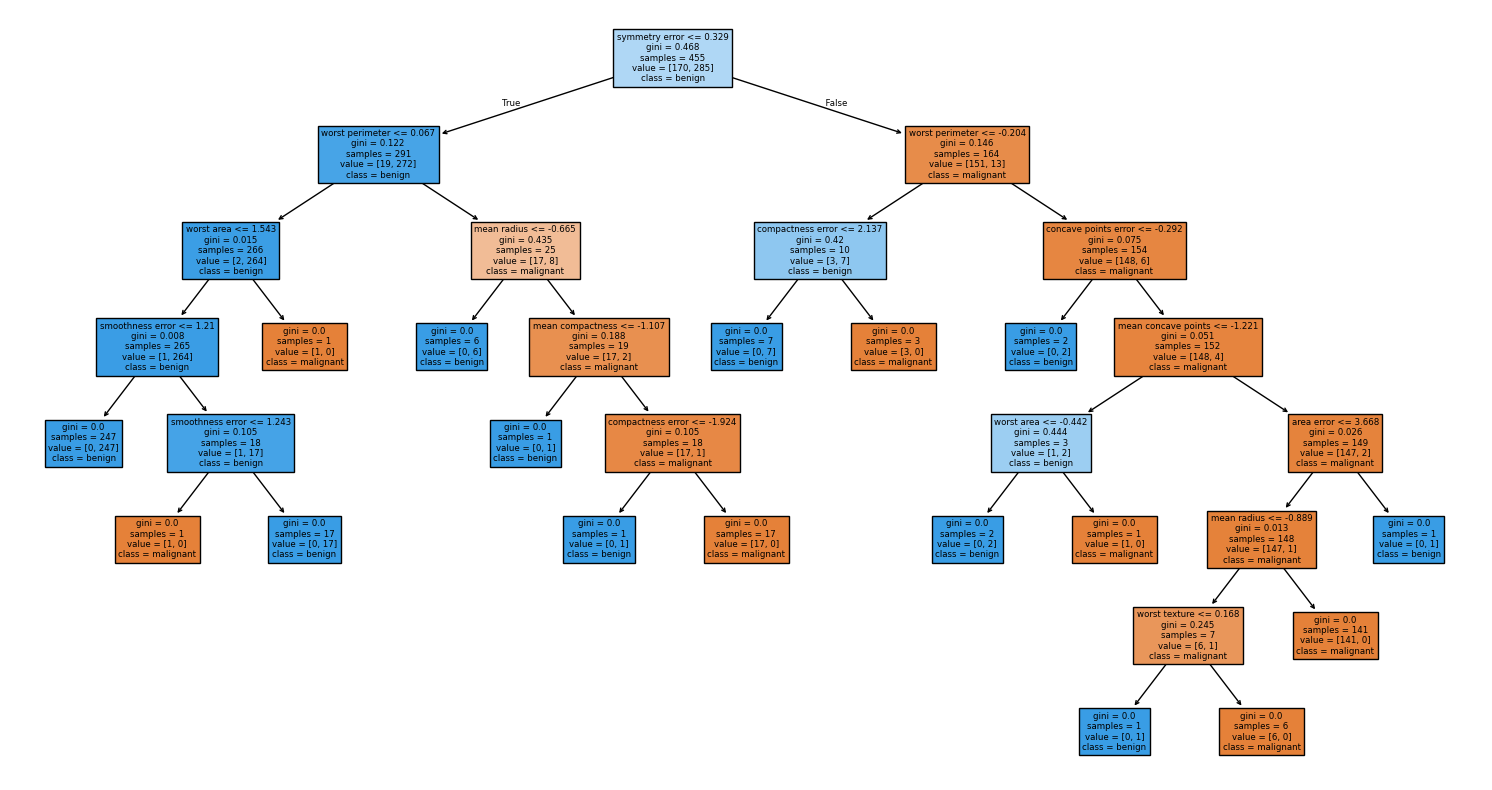

In [23]:
plt.figure(figsize = (19, 10))

plot_tree(dt_clf, feature_names = feature_names, class_names = target_names, filled=True)

plt.show()

In [24]:
dtc_y_test_pred = dt_clf.predict(X_test)
# dtc_y_test_pred

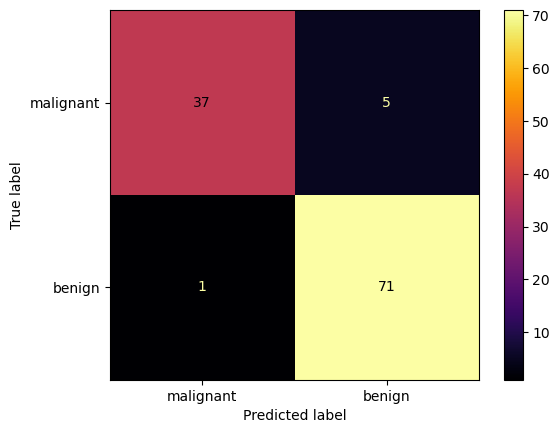

In [25]:
dtc_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    dtc_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [26]:
print(classification_report(
    y_test,
    dtc_y_test_pred,
    target_names = target_names
))

              precision    recall  f1-score   support

   malignant       0.97      0.88      0.93        42
      benign       0.93      0.99      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



In [27]:
print(accuracy_score(
    y_test,
    dtc_y_test_pred
))

0.9473684210526315


# Using RandomForest

## Performing GridSearch

In [28]:
params = {
    'n_estimators': np.arange(1, 21, 1),
    'max_depth': np.arange(1, 21, 1),
}

In [29]:
rf_cv = GridSearchCV(RandomForestClassifier(),
                     param_grid=params,
                     scoring='accuracy',
                     )

rf_cv.fit(X_train, y_train)

C:\Users\harri\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

In [30]:
# rf_clf = RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
rf_clf = rf_cv.best_estimator_

In [31]:
rf_y_test_pred = rf_clf.predict(X_test)

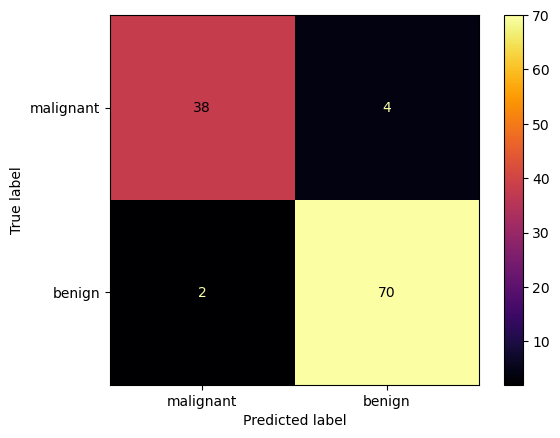

In [32]:
rf_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    rf_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [33]:
print(classification_report(
    y_test,
    rf_y_test_pred,
    target_names=target_names
))

              precision    recall  f1-score   support

   malignant       0.95      0.90      0.93        42
      benign       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [34]:
print(accuracy_score(
    y_test,
    rf_y_test_pred
))

0.9473684210526315


# Using Gaussian Naive Bayes

In [35]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

In [36]:
gnb_y_test_pred = gnb_clf.predict(X_test)

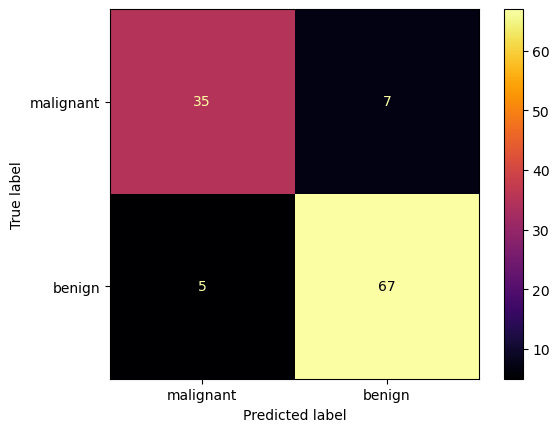

In [37]:
gnb_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    gnb_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [38]:
print(classification_report(
    y_test,
    gnb_y_test_pred,
    target_names=target_names
))

              precision    recall  f1-score   support

   malignant       0.88      0.83      0.85        42
      benign       0.91      0.93      0.92        72

    accuracy                           0.89       114
   macro avg       0.89      0.88      0.89       114
weighted avg       0.89      0.89      0.89       114



In [39]:
print(accuracy_score(
    y_test,
    gnb_y_test_pred
))

0.8947368421052632
